# Result comparison for AL

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
print('loading')
from pathlib import Path

loading


In [39]:
num_trails = 9
if num_trails < 8:
    alpha = 0.5
else:
    alpha = 0.2
SMOOTH_WEIGHT=0.2
plot_var = True
plot_na = True
plot_namd = True
#MSE_retrain_False_bs_1024_pool_10_dx_5_x0_20_nmod_5
#folder = 'results/fig'
folder = '/home/sr365/NAAL/results/fig/retrain_True'
#folder = '/home/sr365/NAAL/results/fig/retrain_False'
#folder = 'results/fig/retrain_true_al_step_50/x0_20'

# folder_list = ['/home/sr365/NAAL/results/30_sine_nmod_20_add_noise_add_2',
#                 '/home/sr365/NAAL/results/30_sine_nmod_20_add_noise_mult_5',
#                 '/home/sr365/NAAL/results/30_sine_nmod_20_add_noise_mult_2']
folder_list = ['/home/sr365/NAAL/results/BN_xsinsinx_f_30_num_layer_9_nmod_10_to1250_dx_10_pool_mul_5_naal_True']
                # '/home/sr365/NAAL/results/BN_xsinsinx_f_30_num_layer_9_nmod_5_to2000_dx_10_pool_mul_20_naal_True']
                # '/home/sr365/NAAL/results/BN_xsinsinx_f_30_num_layer_7_nmod_10_to1000_dx_10_pool_mul_10_naal_True']
                # '/home/sr365/NAAL/results/no_BN_xsinx_f_30_num_layer_10_nmod_10_to600_dx_20_pool_mul_20_naal_True',
                # '/home/sr365/NAAL/results/no_BN_xsinx_f_30_num_layer_10_nmod_10_to600_dx_20_pool_mul_5_naal_True']
                # '/home/sr365/NAAL/results/30_sine_num_layer_7_nmod_10_to500_dx_20_pool_mul_10',
                # '/home/sr365/NAAL/results/30_sine_num_layer_7_nmod_10_to2000_dx_100_pool_mul_5']
# folder_list = ['results/30_sine_nmod']
random_folder_provide = None
#random_folder_provide = '/home/sr365/NAAL/results/30_sine_num_layer_7_nmod_1_to10000_dx_500_pool_mul_10/Random_retrain_False_bs_10000_pool_5000_dx_500_step_19_x0_100_nmod_1_trail_9'

In [40]:
def load_mses(folder):
    """
    Load the mses of a certain model, being called by the aggregate function below
    """
    try:
        test_mse = np.load(os.path.join(folder, 'test_mse.npy'))
        train_mse = np.load(os.path.join(folder, 'train_mse.npy'))
        selected_after_train_mse = np.load(os.path.join(folder, 'mse_selected_after_train.npy'))
    except:
        print("The retrain is True did not exist, using retrain false as proxy")
        folder_new = folder.replace('retrain_True','retrain_False')
        test_mse = np.load(os.path.join(folder_new, 'test_mse.npy'))
        train_mse = np.load(os.path.join(folder_new, 'train_mse.npy'))
        selected_after_train_mse = np.load(os.path.join(folder_new, 'mse_selected_after_train.npy'))
    return test_mse, train_mse, selected_after_train_mse

def load_ensemble_mses(folder, num_trails, avg_test_mse_mat=None, avg_train_mse_mat=None, avg_selected_after_train_mse_mat=None):
    """
    Load multiple mse file from different trails from num_trails parameter and 
    aggregate them by taking mean
    """
    if avg_test_mse_mat is None:
        avg_test_mse_mat, avg_train_mse_mat, avg_selected_after_train_mse_mat = load_matrix(folder, num_trails)
    # Take the average
    return np.mean(avg_test_mse_mat, axis=1), np.mean(avg_train_mse_mat, axis=1), np.mean(avg_selected_after_train_mse_mat, axis=1)

def load_matrix(folder, num_trails):
    """
    As the error is prone to outlier in the x value, therefore we can not simply do average (the outliers have explicitly higher weights)
    Here we are showing the ratio of training and testing
    """
    avg_test_mse_mat, avg_train_mse_mat, avg_selected_after_train_mse_mat = [], [], []
    for i in range(num_trails):
        # Replace to get the new folder name
        folder_name = folder.replace('trail_0','trail_{}'.format(i))
        # From folder name get all the mse lists
        test_mse, train_mse, selected_after_train_mse = load_mses(folder_name)
        # Average them
        avg_test_mse_mat.append(test_mse)
        avg_train_mse_mat.append(train_mse)
        avg_selected_after_train_mse_mat.append(selected_after_train_mse)
    avg_test_mse_mat = np.array(avg_test_mse_mat).transpose()
    avg_train_mse_mat = np.array(avg_train_mse_mat).transpose()
    avg_selected_after_train_mse_mat = np.array(avg_selected_after_train_mse_mat).transpose()
    print('shape = ', np.shape(avg_test_mse_mat))
    return avg_test_mse_mat, avg_train_mse_mat, avg_selected_after_train_mse_mat

def load_coeff(folder, num_trails, mode):
    """
    Loading the variance coefficient with real MSE
    """
    var_coeff_mat = []
    if mode == 'R':
        npy_file = 'var_mse_coreff.npy'
    elif mode == 'Tau':
        npy_file = 'var_mse_tau.npy'
    for i in range(num_trails):
        folder_name = folder.replace('trail_0','trail_{}'.format(i))
        file_name = os.path.join(folder_name, npy_file)
        coef_list = np.load(file_name)
        var_coeff_mat.append(np.copy(coef_list))
    return var_coeff_mat

def load_kendal_tau(folder, num_trails):
    """
    Loading the variance Kendal's Tau 
    """
    return load_coeff(folder, num_trails, mode='Tau')

def load_var_coeff(folder, num_trails):
    """
    Loading the variance coefficient with real MSE
    """
    return load_coeff(folder, num_trails, mode='R')


In [41]:
def smooth(scalars, weight=SMOOTH_WEIGHT):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

##########################################
# Plotting various MSE metrics together #
##########################################
def plot_various_MSE(x_label, MSE_test_mse, RD_test_mse, MSE_train_mse, RD_train_mse, VAR_test_mse, VAR_train_mse, plot_var, save_name):
    f = plt.figure(figsize=[8, 4])
    #ax1 = plt.subplot(211)
    plt.plot(x_label, MSE_test_mse, '-x', c='tab:blue', label='MSE test')
    plt.plot(x_label, RD_test_mse, '-x', c='tab:orange', label='RD test')
    plt.plot(x_label, MSE_train_mse, '--x', c='tab:blue', linewidth=2, label='MSE train')
    plt.plot(x_label, RD_train_mse, '--x', c='tab:orange', linewidth=2, label='RD train')
    if plot_var:
        plt.plot(x_label, VAR_test_mse, '-x', c='tab:green', label='VAR test')
        plt.plot(x_label, VAR_train_mse, '--x', c='tab:green', linewidth=2, label='VAR train')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('num_train')
    plt.ylabel('MSE')
    plt.title(os.path.basename(save_name))
    plt.savefig(save_name+'.png')
    plt.clf()

###################################
# Plotting AL/Raondom Ratio plot #
###################################
def plot_ratio(num, denom, x_value, ylabel, save_name, x_label):
    # Get the MSE/Random ratio
    test_mse_ratio = num / denom
    test_mse_ratio = np.log(test_mse_ratio)
    percent_better = np.mean(test_mse_ratio < 0)
    #test_mse_ratio[test_mse_ratio < 1] = -np.log(1/test_mse_ratio[test_mse_ratio < 1])
    #test_mse_ratio[test_mse_ratio >= 1] = np.log(test_mse_ratio[test_mse_ratio >= 1])
    # Plot the ratio figure
    f = plt.figure(figsize=[8, 4])
    for i in range(num_trails):
        plt.plot(x_value, test_mse_ratio[:, i],'x')
    plt.plot(x_value, np.zeros_like(x_label),'--r', label='ref: {:.1f}%'.format(percent_better*100))
    plt.legend()
    #plt.ylim([-2, 2])
    plt.yscale('log')
    plt.xlabel('num_train')
    plt.ylabel(ylabel)
    plt.title(os.path.basename(save_name))
    plt.savefig(save_name + 'ratio_plot.png')
    plt.clf()

#######################################
# Plotting Test MSE comparison plot #
#######################################
def plot_test_MSE_plot(x_label, MSE_test_mse_mat, Random_test_mse_mat, save_name, VAR_test_mse_mat=None, 
                    NA_test_mse_mat=None, plot_var=True, alpha=0.2, random_folder_provide=None,NAMD_test_mse_mat=None):
    
    if random_folder_provide:
        x_label_rand = get_x_label_from_folder_name(random_folder_provide)
    else:
        x_label_rand = x_label
    # Get the comparison plot for all
    f = plt.figure(figsize=[8, 4])
    # For easy legend
    plt.plot(x_label, MSE_test_mse_mat[:, 0], '-', alpha=alpha,  c='tab:blue', label='AL')
    plt.plot(x_label_rand, Random_test_mse_mat[:, 0], '-', alpha=alpha,  c='tab:orange', label='Random')
    if plot_var:
        plt.plot(x_label, VAR_test_mse_mat[:, 0], '-', alpha=alpha,  c='tab:green', label='VAR')
    if plot_na:
        plt.plot(x_label, NA_test_mse_mat[:, 0], '-', alpha=alpha,  c='tab:brown', label='NA')
    if plot_namd:
        plt.plot(x_label[:len(NAMD_test_mse_mat[:, 0])], NAMD_test_mse_mat[:, 0], '-', alpha=alpha,  c='tab:red', label='NAMD')
    for i in range(1, num_trails):
        plt.plot(x_label, MSE_test_mse_mat[:, i], '-', alpha=alpha,  c='tab:blue')
        plt.plot(x_label_rand, Random_test_mse_mat[:, i], '-', alpha=alpha,  c='tab:orange')
        if plot_var:
            plt.plot(x_label, VAR_test_mse_mat[:, i], '-', alpha=alpha,  c='tab:green')
        if plot_na:
            plt.plot(x_label, NA_test_mse_mat[:, i], '-', alpha=alpha,  c='tab:brown')
        if plot_namd:
            plt.plot(x_label[:len(NAMD_test_mse_mat[:, i])], NAMD_test_mse_mat[:, i], '-', alpha=alpha,  c='tab:red')
    plt.xlabel('num_train')
    plt.ylabel('MSE')
    plt.yscale('log')
    # plt.xscale('log')
    plt.legend()
    plt.title(os.path.basename(save_name))
    plt.savefig(save_name + 'test_loss_overlay.png')

###################################
# # Plotting VAR correlation plot #
###################################
def plot_coref(cur_folder, num_trails, save_name, coef_loader, coef_name):
    f = plt.figure(figsize=[8, 4])
    var_folder = cur_folder.replace('MSE','VAR')
    coeff = coef_loader(var_folder, num_trails)
    for i in range(num_trails):
        plt.plot(coeff[i], 'x', alpha=0.2)
    plt.ylim([0, 1])
    plt.xlabel('epoch')
    plt.ylabel('correlation')
    plt.savefig(save_name + coef_name + '_cor.png')

#######################################################
# Plot the Data efficiency plot here#
#######################################################
def Data_efficiency_plot(x_label, MSE_test_mse_mat, Random_test_mse_mat, save_name, VAR_test_mse_mat, NA_test_mse_mat, plot_var=True,
                    mse_upper_bound=0.1, num_points=20, y_lim=None, random_folder_provide=None,NAMD_test_mse_mat=None):
    """
    The is the data efficiency plot function.
    The X axis is the MSE level that it can get
    The y axis is the number of training data it needs to get to that position
    """

    f = plt.figure(figsize=[8, 4])
    if VAR_test_mse_mat is None:
        VAR_test_mse_mat = Random_test_mse_mat
    
    VAR_efficiency_mat, MSE_efficiency_mat,  = np.zeros([num_trails,num_trails, num_points]), np.zeros([num_trails,num_trails, num_points])
    NA_efficiency_mat, NAMD_efficiency_mat= np.zeros([num_trails,num_trails, num_points]), np.zeros([num_trails,num_trails, num_points])
    # First of all, get the x axis points
    for i in range(num_trails):
        for k in range(num_trails):
            # Get the each of the MSE for single trail
            VAR_mse = VAR_test_mse_mat[:, i]
            RD_mse = Random_test_mse_mat[:, k]          # This is the reference point, which is governed by k
            MSE_mse = MSE_test_mse_mat[:, i]
            NA_mse = NA_test_mse_mat[:, i]
            if plot_namd:
                NAMD_mse = NAMD_test_mse_mat[:, i]
            # Get the MSE min and max
            MSE_max = np.min([np.max(VAR_mse), np.max(RD_mse), np.max(MSE_mse), np.max(NA_mse), mse_upper_bound])
            MSE_min = np.max([np.min(VAR_mse), np.min(RD_mse), np.min(MSE_mse), np.min(NA_mse)])
            # Get the X-axis
            MSE_list = np.linspace(np.log(MSE_min), np.log(MSE_max), num=num_points)
            # Get the Y-axis
            for j in range(len(MSE_list)):
                mse_cur = np.exp(MSE_list[j])
                num_train_RD = x_label[np.argmin(np.square(RD_mse - mse_cur))]
                num_train_MSE = x_label[np.argmin(np.square(MSE_mse - mse_cur))]
                num_train_VAR = x_label[np.argmin(np.square(VAR_mse - mse_cur))]
                num_train_NA = x_label[np.argmin(np.square(NA_mse - mse_cur))]
                VAR_efficiency_mat[i, k, j] = num_train_VAR/num_train_RD
                MSE_efficiency_mat[i, k, j] = num_train_MSE/num_train_RD
                NA_efficiency_mat[i, k, j] = num_train_NA/num_train_RD
                if plot_namd:
                    num_train_NAMD = x_label[np.argmin(np.square(NAMD_mse - mse_cur))]
                    NAMD_efficiency_mat[i, k, j] = num_train_NAMD/num_train_RD
    for i in range(num_trails):
        for k in range(num_trails):
            # # Start the plotting
            # if i == 0:
            #     plt.plot(np.exp(MSE_list), MSE_efficiency_mat[i, :], '--x',c='tab:blue', label='MSE efficiency',alpha=alpha)
            #     if plot_var:
            #         plt.plot(np.exp(MSE_list), VAR_efficiency_mat[i, :], '--x',c='tab:green', label='VAR efficiency',alpha=alpha)
            #     if plot_na:
            #         plt.plot(np.exp(MSE_list), NA_efficiency_mat[i, :], '--x',c='tab:purple', label='NA efficiency',alpha=alpha)
            # else:
            plt.plot(np.exp(MSE_list), MSE_efficiency_mat[i,k, :], '--x', c='tab:blue',alpha=alpha*alpha)
            if plot_var:
                plt.plot(np.exp(MSE_list), VAR_efficiency_mat[i, k, :], '--x',c='tab:green',alpha=alpha*alpha)
            if plot_na:
                plt.plot(np.exp(MSE_list), NA_efficiency_mat[i, k, :], '--x',c='m',alpha=alpha*alpha)
            if plot_namd:
                plt.plot(np.exp(MSE_list), NAMD_efficiency_mat[i, k, :], '--x',c='tab:red',alpha=alpha*alpha)
    #print(len(MSE_efficiency_mat))
    #print(np.shape(np.array(MSE_efficiency_mat)))
    plt.plot(np.exp(MSE_list), np.mean(np.mean(MSE_efficiency_mat, axis=0), axis=0), '-x', c='b', label='MSE mean')
    if plot_var:
        plt.plot(np.exp(MSE_list), np.mean(np.mean(VAR_efficiency_mat, axis=0), axis=0), '-x', c='g', label='VAR mean')
    if plot_na:
        plt.plot(np.exp(MSE_list), np.mean(np.mean(NA_efficiency_mat, axis=0), axis=0), '-x', c='m', label='NA mean')
    if plot_namd:
        plt.plot(np.exp(MSE_list), np.mean(np.mean(NAMD_efficiency_mat, axis=0), axis=0), '-x', c='r', label='NAMD mean')
    plt.xlabel('MSE')
    plt.ylabel('Efficiency')
    plt.xscale('log')
    plt.gca().invert_xaxis()
    if y_lim:
        plt.ylim([0, y_lim])
    plt.grid()
    plt.legend()
    plt.savefig(save_name + '_data_efficiency.png')
    
def get_dx_x0(name):
    """
    Get the dx and x0 from a name
    """
    dx = int(name.split('_dx_')[-1].split('_')[0])
    x0 = int(name.split('_x0_')[-1].split('_')[0])
    print('for {}, dx = {}, x0 = {}'.format(name, dx, x0))
    return dx, x0

def get_x_label_from_folder_name(random_folder_provide):
    for file in os.listdir(random_folder_provide):
        cur_folder = os.path.join(random_folder_provide, file)
        if not os.path.isdir(cur_folder):
            continue
        dx, x0 = get_dx_x0(cur_folder)
        mse = np.load(os.path.join(cur_folder, 'test_mse'))
        print('len of mse in get x label', np.len(mse))
        x_label = np.array(range(len(mse))) * dx + x0
        print('x_label = ', x_label)
        return x_label

shape =  (123, 9)
shape =  (123, 9)
shape =  (123, 9)
shape =  (123, 9)
['/home/sr365/NAAL/results/BN_xsinsinx_f_30_num_layer_9_nmod_10_to1250_dx_10_pool_mul_5_naal_True/xsinsinx_NAMD_POW_retrain_False_complexity_9_bs_5000_pool_200_dx_10_step_58_x0_20_nmod_10_trail_0']
shape =  (58, 9)
for xsinsinx_MSE_retrain_False_complexity_9_bs_5000_pool_50_dx_10_step_123_x0_20_nmod_10_trail_0, dx = 10, x0 = 20


<Figure size 576x288 with 0 Axes>

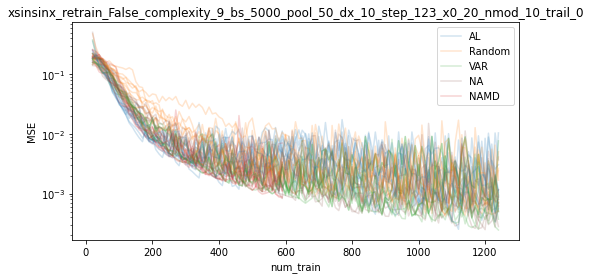

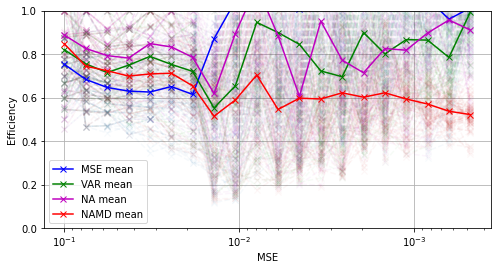

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

In [42]:
for folder in folder_list:
    for file in os.listdir(folder):
        cur_folder = os.path.join(folder, file)
        # Makue sure this is a folder
        if not os.path.isdir(cur_folder):
            continue
        # print(cur_folder)
        # Only start from the M SE folders and look for comparison
        if not 'MSE' in cur_folder or not 'trail_0' in cur_folder:# or 'retrain_True' in cur_folder:
            continue
        
        VAR_test_mse_mat = None # This is for the case where it is not called

        # The reading part
        #MSE_test_mse, MSE_train_mse, MSE_selected_after_train_mse = load_mses(cur_folder)
        MSE_test_mse_mat, MSE_train_mse_mat, MSE_selected_after_train_mse_mat = load_matrix(cur_folder, num_trails)
        MSE_test_mse, MSE_train_mse, MSE_selected_after_train_mse = load_ensemble_mses(cur_folder, num_trails, MSE_test_mse_mat, MSE_train_mse_mat, MSE_selected_after_train_mse_mat)
        
        # This is the case where random is taken from the same folder
        if random_folder_provide is None:
            random_folder = cur_folder.replace('MSE','Random')
        else:
            random_folder = random_folder_provide
        #RD_test_mse, RD_train_mse, RD_selected_after_train_mse = load_mses(random_folder)
        Random_test_mse_mat, Random_train_mse_mat, Random_selected_after_train_mse_mat = load_matrix(random_folder, num_trails)
        RD_test_mse, RD_train_mse, RD_selected_after_train_mse = load_ensemble_mses(random_folder, num_trails, Random_test_mse_mat, Random_train_mse_mat, Random_selected_after_train_mse_mat)

        if plot_var:
            # Var plotting
            var_folder = cur_folder.replace('MSE','VAR')#.replace('pool_100','pool_500')
            VAR_test_mse_mat, VAR_train_mse_mat, VAR_selected_after_train_mse_mat = load_matrix(var_folder, num_trails)
            VAR_test_mse, VAR_train_mse, VAR_selected_after_train_mse = load_ensemble_mses(var_folder, num_trails, VAR_test_mse_mat, VAR_train_mse_mat, VAR_selected_after_train_mse_mat)

        if plot_na:
            na_folder = cur_folder.replace('MSE','NA')
            NA_test_mse_mat, NA_train_mse_mat, NA_selected_after_train_mse_mat = load_matrix(na_folder, num_trails)
            NA_test_mse, NA_train_mse, NA_selected_after_train_mse = load_ensemble_mses(na_folder, num_trails, NA_test_mse_mat, NA_train_mse_mat, NA_selected_after_train_mse_mat)

        if plot_namd:
            # Using the ambiguous matching scheme with glob
            cur_path = Path(cur_folder)
            glob_list = glob(os.path.join(cur_path.parent ,'*NAMD_POW_*'+cur_folder.split('trail_')[-1]))
            print(glob_list)
            assert len(glob_list) == 1, 'your glob list is not 1 in the NAMD folder retrieving'
            namd_folder = glob_list[0]
            # name_folder = cur_folder.replace('MSE','NAMD+RAD005')
            NAMD_test_mse_mat, NAMD_train_mse_mat, NAMD_selected_after_train_mse_mat = load_matrix(namd_folder, num_trails)
            NAMD_test_mse, NAMD_train_mse, NAMD_selected_after_train_mse = load_ensemble_mses(namd_folder, num_trails, NAMD_test_mse_mat, NAMD_train_mse_mat, NAMD_selected_after_train_mse_mat)


        # Smoothing step
        for i in range(np.shape(MSE_test_mse_mat)[1]):
            MSE_test_mse_mat[:, i] = smooth(MSE_test_mse_mat[:, i])
            Random_test_mse_mat[:, i] = smooth(Random_test_mse_mat[:, i])
            if plot_na:
                NA_test_mse_mat[:, i] = smooth(NA_test_mse_mat[:, i])
            if plot_var:
                VAR_test_mse_mat[:, i] = smooth(VAR_test_mse_mat[:, i])
            if plot_namd:
                NAMD_test_mse_mat[:, i] = smooth(NAMD_test_mse_mat[:, i])

        # Get the dx and x0
        dx, x0 = get_dx_x0(file)
        # Use the xlabel with number of data points
        x_label = np.array(range(len(MSE_test_mse))) * dx + x0
        save_name = os.path.join(folder, file.replace('MSE_','').replace('_trail_0_',''))

        # One-liner calling functions
        # plot_various_MSE(x_label, MSE_test_mse, RD_test_mse, MSE_train_mse, RD_train_mse, VAR_test_mse, VAR_train_mse, plot_var, save_name)     # Plot the various MSE
        if not random_folder_provide:
            plot_ratio(MSE_test_mse_mat, Random_test_mse_mat, x_label, ylabel='MSE / Random Ratio', save_name=save_name + 'MSE_RD_', x_label=x_label)                # Plot the ratio plot between MSE and random
        plot_test_MSE_plot(x_label, MSE_test_mse_mat, Random_test_mse_mat, save_name, NA_test_mse_mat=NA_test_mse_mat,
                        VAR_test_mse_mat=VAR_test_mse_mat, random_folder_provide=random_folder_provide,
                        NAMD_test_mse_mat=NAMD_test_mse_mat, plot_var=plot_var)     # Plot the test MSE line plot
        Data_efficiency_plot(x_label, MSE_test_mse_mat, Random_test_mse_mat, save_name, 
                        VAR_test_mse_mat, NA_test_mse_mat, y_lim=1,random_folder_provide=random_folder_provide,
                        NAMD_test_mse_mat=NAMD_test_mse_mat, plot_var=plot_var)                             # Plot the data efficiency plot
        if plot_var and not random_folder_provide:    # For variance experiments 
            plot_ratio(VAR_test_mse_mat, Random_test_mse_mat, x_label, ylabel='VAR / Random Ratio', save_name=save_name + 'VAR_RD_', x_label=x_label)            # Plot the ratio plot between VAR and random
        if plot_na and not random_folder_provide:    # For variance experiments 
            plot_ratio(NA_test_mse_mat, Random_test_mse_mat, x_label, ylabel='NA / Random Ratio', save_name=save_name + 'NA_RD_', x_label=x_label)            # Plot the ratio plot between VAR and random
        
        #     plot_coref(cur_folder, num_trails, save_name, coef_loader=load_var_coeff, coef_name='VAR')                                                                                       # Plot the VAR R coeff plot
            #plot_coref(cur_folder, num_trails, save_name, coef_laoder=load_kendal_tau, coef_name='Tau')                                         # Plot the VAR Tau coeff plot   

        plt.clf()
        

# Testing the numpy random seed

In [ ]:
import numpy as np
np.random.seed(1)
print(np.random.uniform(10))
print(np.random.uniform(0, 5, 10))


In [ ]:
np.random.seed(1)
print(np.random.uniform(10))
print(np.random.uniform(0, 5, 10))